# Temperature Data 

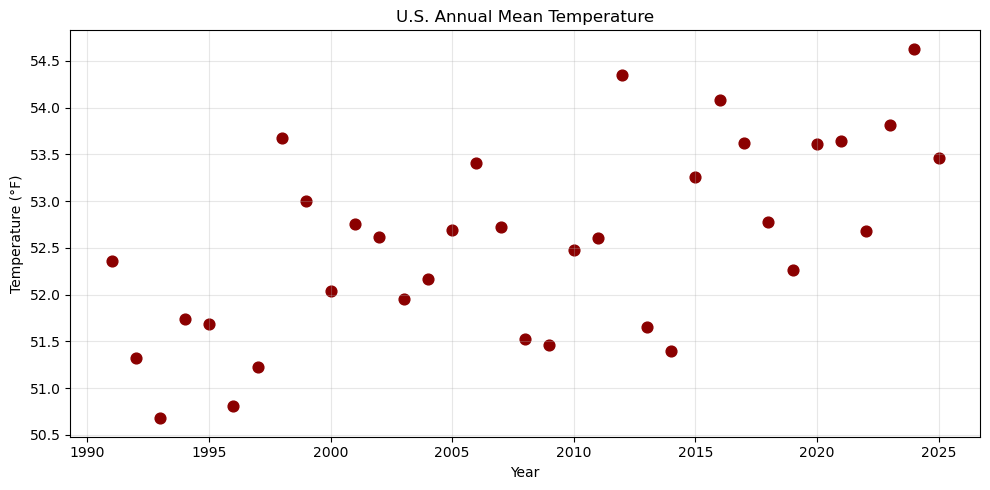

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv")
national = df.groupby("Year")["Temperature"].mean()

plt.figure(figsize=(10, 5))
plt.scatter(national.index, national.values, c='darkred', s=60)
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")
plt.title("U.S. Annual Mean Temperature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

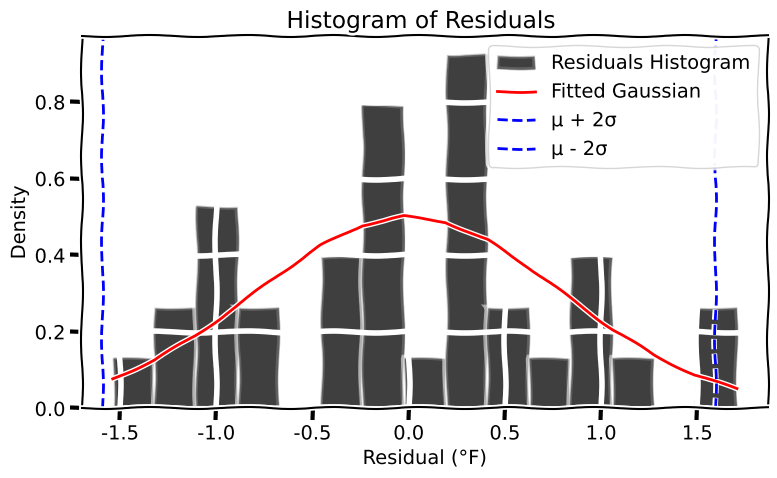

Standard deviation of residuals (σ) = 0.796 °F


In [11]:
from scipy.stats import norm, linregress
mu, sigma = norm.fit(residuals)
#  add the sigma to the histogram plot as vertical lines
with plt.xkcd():
    plt.figure(figsize=(8, 5))
    count, bins, ignored = plt.hist(residuals, bins=15, density=True, color='black', alpha=0.5, edgecolor='white', label='Residuals Histogram')
    plt.plot(bins, norm.pdf(bins, mu, sigma), 'r-', linewidth=2, label='Fitted Gaussian')
    plt.axvline(mu + 2*sigma, color='blue', linestyle='--', label='μ + 2σ')
    plt.axvline(mu - 2*sigma, color='blue', linestyle='--', label='μ - 2σ')
    plt.title("Histogram of Residuals ")
    plt.xlabel("Residual (°F)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Standard deviation of residuals (σ) = {sigma:.3f} °F")


In [27]:
print("Slope with uncertainty?")
print(f" {slope:.1f} °F/year ± {sigma:.1f} °F/year")

Slope with uncertainty?
 0.1 °F/year ± 0.8 °F/year


# We can do better!

Years: 1991–2025  (n=35)
Latest observed: 53.462 °F

Most recent year:
  Observed     : 53.462 °F
  Random Forest smoothed prediction: 53.803 °F



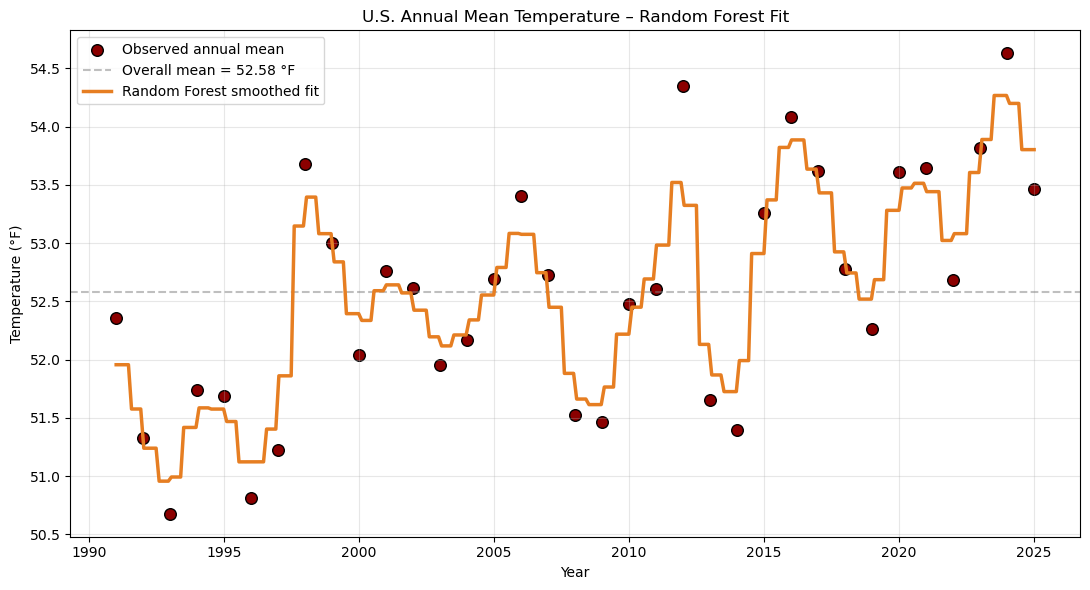

In [39]:
#This code produces the random forest fit to the temperature data 
# The oscillations resemble ENSO.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Load data
try:
    df = pd.read_csv("data.csv")
except FileNotFoundError:
    print("Error: data.csv not found")
    exit(1)

# Quick national annual means
national = df.groupby("Year")["Temperature"].mean().reset_index()

years = national["Year"].values
temps = national["Temperature"].values

if len(years) < 2:
    print("Not enough data points")
    exit(1)

print(f"Years: {years.min()}–{years.max()}  (n={len(years)})")
print(f"Latest observed: {temps[-1]:.3f} °F\n")

# Prepare data for smooth prediction
X = years.reshape(-1, 1)
X_smooth = np.linspace(years.min(), years.max(), 300).reshape(-1, 1)

# Random Forest
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X, temps)
rf_pred = rf.predict(X_smooth)

latest_rf = rf.predict([[years[-1]]])[0]

# Summary
print("Most recent year:")
print(f"  Observed     : {temps[-1]:.3f} °F")
print(f"  Random Forest smoothed prediction: {latest_rf:.3f} °F\n")

# Plot
plt.figure(figsize=(11, 6))

plt.scatter(years, temps, c='darkred', edgecolor='black', s=70, label='Observed annual mean')
plt.axhline(temps.mean(), color='gray', ls='--', alpha=0.5,
            label=f'Overall mean = {temps.mean():.2f} °F')

plt.plot(X_smooth, rf_pred, color='#e67e22', lw=2.5,
         label='Random Forest smoothed fit')

plt.title("U.S. Annual Mean Temperature – Random Forest Fit")
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")
plt.grid(alpha=0.3)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Now, the El Nino Southern Oscilations (ENSO) are visible

The period is about 3-7 years, consistent roughly with ENSO, which is not well understood. Let's take a look at the raw data again. 

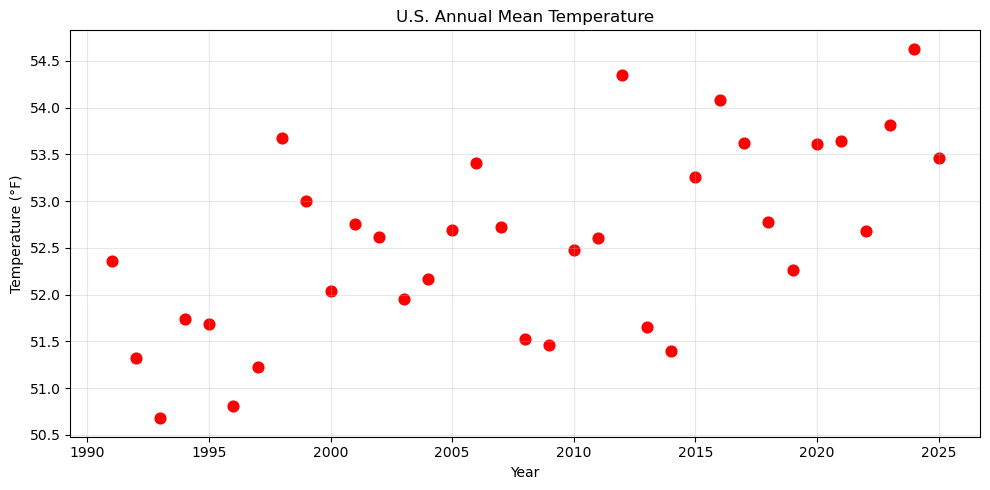

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv")
national = df.groupby("Year")["Temperature"].mean()

plt.figure(figsize=(10, 5))
plt.scatter(national.index, national.values, c='red', s=60)
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")
plt.title("U.S. Annual Mean Temperature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

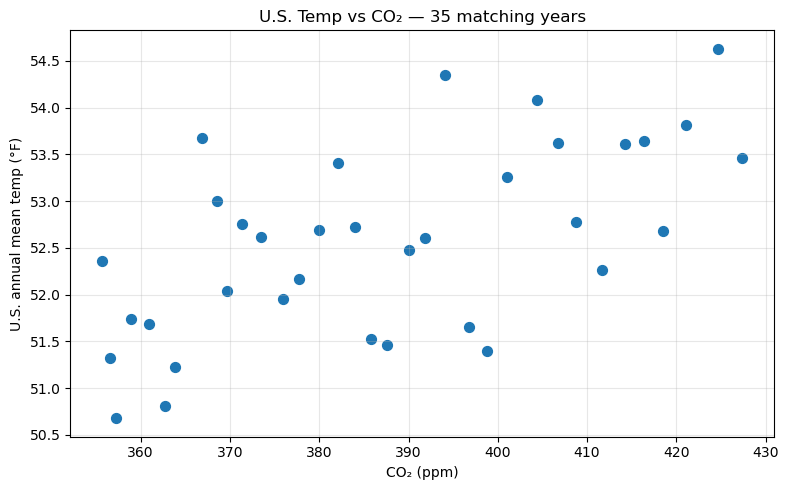

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

temps = pd.read_csv("data.csv")
temps['Year'] = temps['Year'].astype(int)               # force clean integers
temps_annual = temps.groupby("Year")["Temperature"].mean()

co2 = pd.read_csv("co2.txt", sep=r'\s+', comment='#', 
                  usecols=[0,1], names=['year','co2'])
co2['year'] = co2['year'].astype(int)                   # force clean integers

# Merge to ensure only matching years
df = pd.DataFrame({'year': temps_annual.index, 'temp': temps_annual.values}) \
      .merge(co2, on='year')

plt.figure(figsize=(8, 5))
plt.scatter(df['co2'], df['temp'], s=50)
plt.xlabel("CO₂ (ppm)")
plt.ylabel("U.S. annual mean temp (°F)")
plt.title(f"U.S. Temp vs CO₂ — {len(df)} matching years")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Number of matching years: 35
   year       temp     co2
0  1991  52.359524  355.70
1  1992  51.322833  356.54
2  1993  50.676667  357.21
3  1994  51.740000  358.96
4  1995  51.685500  360.97


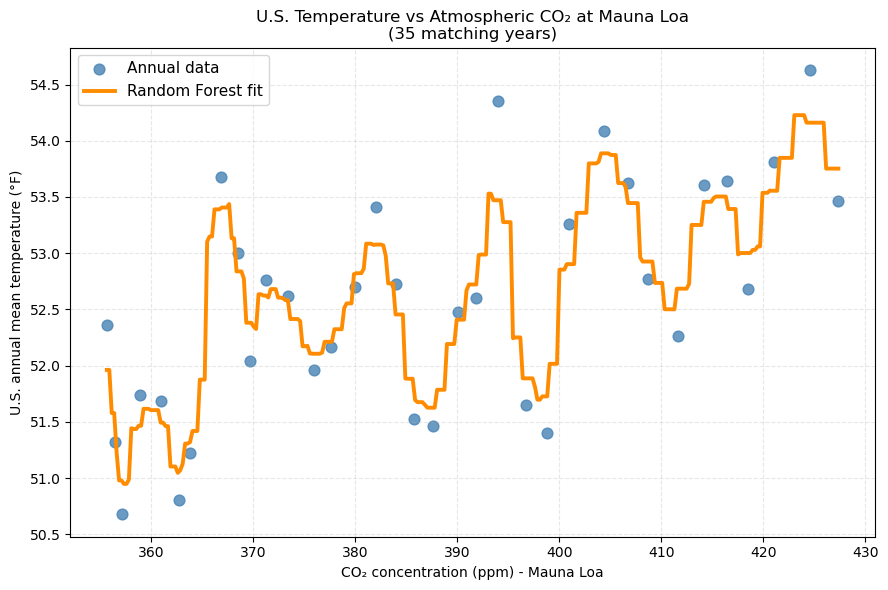

In [53]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 1. Load U.S. temperature data and compute annual means
temps = pd.read_csv("data.csv")
temps_annual = temps.groupby("Year")["Temperature"].mean().reset_index()
temps_annual = temps_annual.rename(columns={"Year": "year", "Temperature": "temp"})

# 2. Load CO₂ data (Mauna Loa style txt file)
co2 = pd.read_csv("co2.txt", 
                  sep=r'\s+', 
                  comment='#', 
                  usecols=[0, 1], 
                  names=['year', 'co2'])

# 3. Merge on year (only keep years present in both datasets)
df = temps_annual.merge(co2, on='year')

# Optional: quick check
print(f"Number of matching years: {len(df)}")
print(df.head())

# 4. Prepare data for model
X = df[['co2']].values          # 2D array (sklearn expects this)
y = df['temp'].values

# 5. Fit Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf.fit(X, y)

# 6. Create smooth prediction curve for plotting
x_smooth = np.linspace(df['co2'].min(), df['co2'].max(), 300).reshape(-1, 1)
y_smooth = rf.predict(x_smooth)

# 7. Plot
plt.figure(figsize=(9, 6))

plt.scatter(df['co2'], df['temp'], 
            s=60, alpha=0.8, color='steelblue', 
            label='Annual data')

plt.plot(x_smooth, y_smooth, 
         color='darkorange', linewidth=2.8, 
         label='Random Forest fit')

plt.xlabel("CO₂ concentration (ppm) - Mauna Loa")
plt.ylabel("U.S. annual mean temperature (°F)")
plt.title(f"U.S. Temperature vs Atmospheric CO₂ at Mauna Loa\n({len(df)} matching years)")
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(frameon=True, fontsize=11)
plt.tight_layout()
plt.show()

# Discussions
Someone might say we are comparing apples to oranges, as we are considering US temperatures vs CO2 at Hawaii. So let's just consider temperatures at Hawaii. 

Number of matching years: 34
   year       temp     co2
0  1992  65.883333  356.54
1  1993  65.091667  357.21
2  1994  65.525000  358.96
3  1995  66.150000  360.97
4  1996  66.225000  362.74


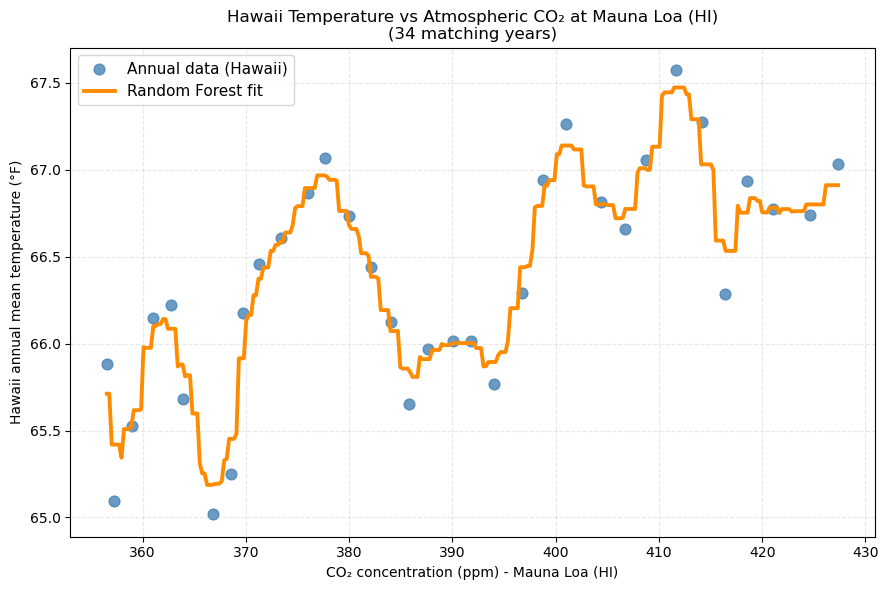

In [80]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 1. Load temperature data and compute annual means *only for Hawaii*
temps = pd.read_csv("data.csv")

# Filter for Hawaii — adjust the column name / value if needed
# Examples of possible filters:
#   - temps = temps[temps['State'] == 'Hawaii']
#   - temps = temps[temps['state'] == 'HI']
#   - temps = temps[temps['Location'].str.contains('Hawaii', case=False)]
temps_hi = temps[temps['State'] == 'HI'].copy()          # ← most common case — change as needed

temps_annual = temps_hi.groupby("Year")["Temperature"].mean().reset_index()
temps_annual = temps_annual.rename(columns={"Year": "year", "Temperature": "temp"})

# 2. Load CO₂ data (Mauna Loa style txt file — very appropriate for Hawaii!)
co2 = pd.read_csv("co2.txt", 
                  sep=r'\s+', 
                  comment='#', 
                  usecols=[0, 1], 
                  names=['year', 'co2'])

# 3. Merge on year (only keep years present in both datasets)
df = temps_annual.merge(co2, on='year')

# Quick check
print(f"Number of matching years: {len(df)}")
print(df.head())

# 4. Prepare data for model
X = df[['co2']].values          # 2D array (sklearn expects this)
y = df['temp'].values

# 5. Fit Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf.fit(X, y)

# 6. Create smooth prediction curve for plotting
x_smooth = np.linspace(df['co2'].min(), df['co2'].max(), 300).reshape(-1, 1)
y_smooth = rf.predict(x_smooth)

# 7. Plot
plt.figure(figsize=(9, 6))

plt.scatter(df['co2'], df['temp'], 
            s=60, alpha=0.8, color='steelblue', 
            label='Annual data (Hawaii)')

plt.plot(x_smooth, y_smooth, 
         color='darkorange', linewidth=2.8, 
         label='Random Forest fit')

plt.xlabel("CO₂ concentration (ppm) - Mauna Loa (HI)")
plt.ylabel("Hawaii annual mean temperature (°F)")
plt.title(f"Hawaii Temperature vs Atmospheric CO₂ at Mauna Loa (HI)\n({len(df)} matching years)")
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(frameon=True, fontsize=11)
plt.tight_layout()
plt.show()

In [94]:


if co2['year'].dtype == float or co2['year'].max() > 10000:
    co2_annual = co2.groupby('year')['co2'].mean().reset_index()
else:
    co2_annual = co2.copy()

df = temps_annual.merge(co2_annual, on='year').sort_values('year')

print(f"Years with both temp & co2: {len(df)}")
print(df.head())
print(df.tail(), "\n")

df['delta_temp'] = df['temp'].diff()
df['delta_co2']  = df['co2'].diff()

changes = df.dropna(subset=['delta_temp', 'delta_co2']).copy()

conditions = [
    (changes['delta_co2'] > 0) & (changes['delta_temp'] > 0),
    (changes['delta_co2'] < 0) & (changes['delta_temp'] < 0),
    (changes['delta_co2'] > 0) & (changes['delta_temp'] < 0),
    (changes['delta_co2'] < 0) & (changes['delta_temp'] > 0),
]

choices = ['positive', 'positive', 'negative', 'negative']

changes['direction'] = np.select(conditions, choices, default='zero')

n = len(changes)
counts = changes['direction'].value_counts()

pos  = counts.get('positive', 0)
neg  = counts.get('negative', 0)
zero = counts.get('zero', 0)

print("Year-to-year movement (Hawaii temperature vs Mauna Loa CO₂):")
print(f"  Both move same direction  : {pos/n*100:5.1f}%  ({pos} years)")
print(f"  Move in opposite directions: {neg/n*100:5.1f}%  ({neg} years)")
print(f"  At least one is flat       : {zero/n*100:5.1f}%  ({zero} years)")
print(f"  Total years compared       : {n}")



Years with both temp & co2: 34
   year       temp     co2
0  1992  65.883333  356.54
1  1993  65.091667  357.21
2  1994  65.525000  358.96
3  1995  66.150000  360.97
4  1996  66.225000  362.74
    year       temp     co2
29  2021  66.283333  416.41
30  2022  66.933333  418.53
31  2023  66.775000  421.08
32  2024  66.741667  424.61
33  2025  67.033333  427.35 

Year-to-year movement (Hawaii temperature vs Mauna Loa CO₂):
  Both move same direction  :  54.5%  (18 years)
  Move in opposite directions:  42.4%  (14 years)
  At least one is flat       :   3.0%  (1 years)
  Total years compared       : 33


What are the chances that increase/decrease in CO2 is accompanied by increase/decrease in Temperature? 



In [100]:
print(f"  {pos/n*100:5.1f}% ")


   54.5% 


What are the chances that increase/decrease in CO2 is accompanied by an opposite movement in Temperature? 


In [106]:
print(f" {neg/n*100:5.1f}% ")


  42.4% 


So CO₂ is not acting as a meaningful driver of temperature on the timescale and in the data we are looking at.

# Let's look at Other States: 

Number of matching years: 35
   year       temp     co2
0  1991  47.133333  355.70
1  1992  48.641667  356.54
2  1993  45.575000  357.21
3  1994  47.900000  358.96
4  1995  47.541667  360.97


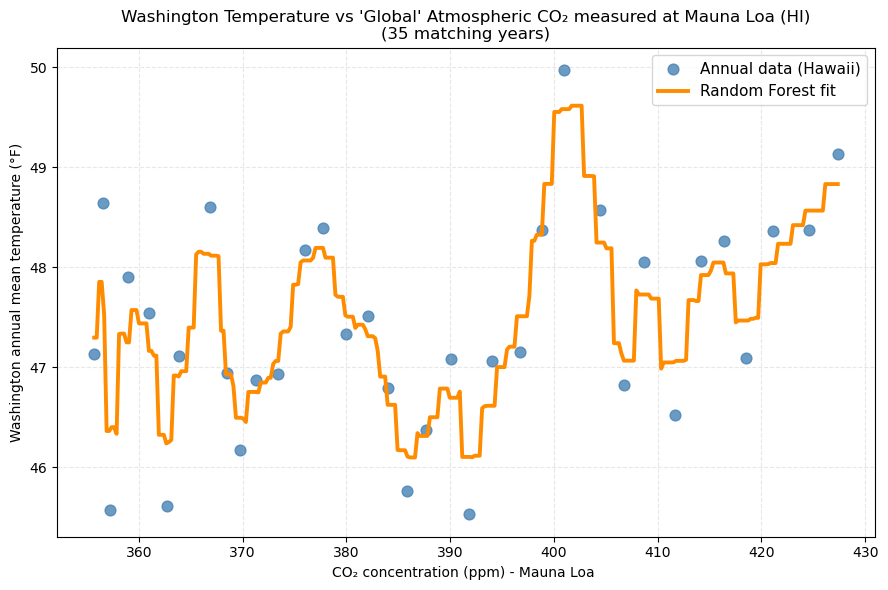

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 1. Load temperature data and compute annual means *only for Hawaii*
temps = pd.read_csv("data.csv")

# Filter for Hawaii — adjust the column name / value if needed
# Examples of possible filters:
#   - temps = temps[temps['State'] == 'Hawaii']
#   - temps = temps[temps['state'] == 'HI']
#   - temps = temps[temps['Location'].str.contains('Hawaii', case=False)]
temps_hi = temps[temps['State'] == 'WA'].copy()          # ← most common case — change as needed

temps_annual = temps_hi.groupby("Year")["Temperature"].mean().reset_index()
temps_annual = temps_annual.rename(columns={"Year": "year", "Temperature": "temp"})

# 2. Load CO₂ data (Mauna Loa style txt file — very appropriate for Hawaii!)
co2 = pd.read_csv("co2.txt", 
                  sep=r'\s+', 
                  comment='#', 
                  usecols=[0, 1], 
                  names=['year', 'co2'])

# 3. Merge on year (only keep years present in both datasets)
df = temps_annual.merge(co2, on='year')

# Quick check
print(f"Number of matching years: {len(df)}")
print(df.head())

# 4. Prepare data for model
X = df[['co2']].values          # 2D array (sklearn expects this)
y = df['temp'].values

# 5. Fit Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf.fit(X, y)

# 6. Create smooth prediction curve for plotting
x_smooth = np.linspace(df['co2'].min(), df['co2'].max(), 300).reshape(-1, 1)
y_smooth = rf.predict(x_smooth)

# 7. Plot
plt.figure(figsize=(9, 6))

plt.scatter(df['co2'], df['temp'], 
            s=60, alpha=0.8, color='steelblue', 
            label='Annual data (Hawaii)')

plt.plot(x_smooth, y_smooth, 
         color='darkorange', linewidth=2.8, 
         label='Random Forest fit')

plt.xlabel("CO₂ concentration (ppm) - Mauna Loa ")
plt.ylabel("Washington annual mean temperature (°F)")
plt.title(f"Washington Temperature vs 'Global' Atmospheric CO₂ measured at Mauna Loa (HI)\n({len(df)} matching years)")
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(frameon=True, fontsize=11)
plt.tight_layout()
plt.show()

# The bigger picture: 

Using 50 states with ≥5 years of data


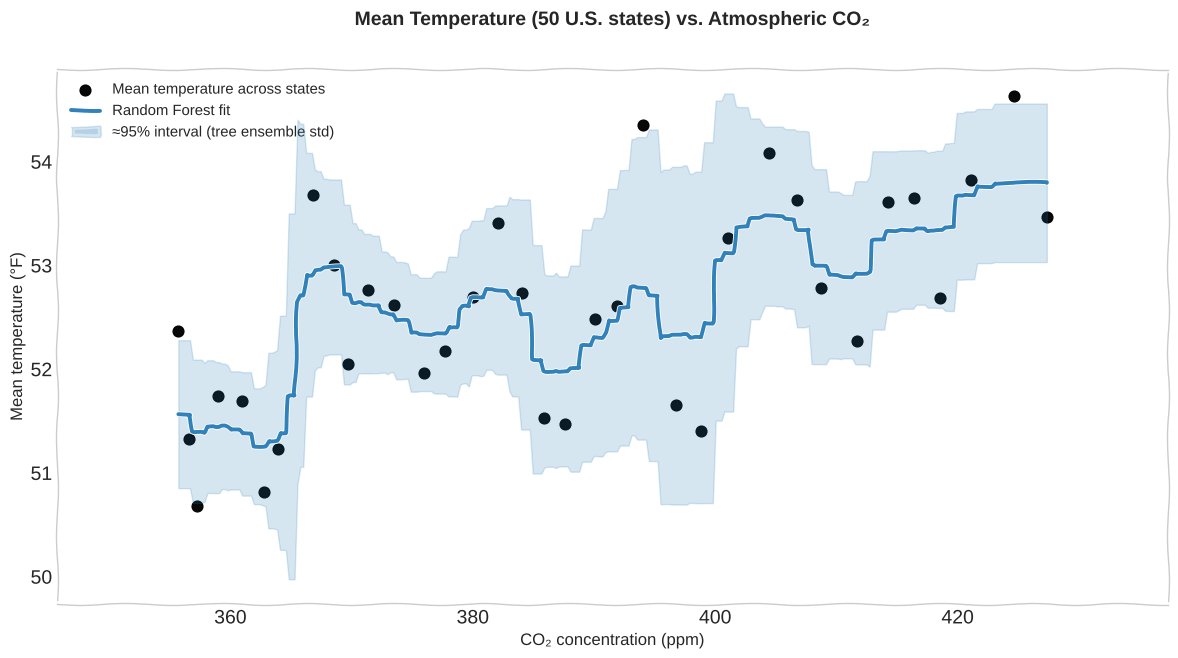

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# ─── File paths & column names ────────────────────────────────
CSV_FILENAME  = "data.csv"       # your state-by-state temperature file
CO2_FILENAME  = "co2.txt"        # Mauna Loa CO₂ file
STATE_COL     = "State"
YEAR_COL      = "Year"
TEMP_COL      = "Temperature"

# ─── Load temperature data ────────────────────────────────────
temps = pd.read_csv(CSV_FILENAME)
annual = temps.groupby([STATE_COL, YEAR_COL])[TEMP_COL].mean().reset_index()
annual = annual.rename(columns={YEAR_COL: 'year', TEMP_COL: 'temp'})

# ─── Load CO₂ data ────────────────────────────────────────────
co2 = pd.read_csv(CO2_FILENAME, sep=r'\s+', comment='#',
                  usecols=[0,1], names=['year','co2'], na_values=[-99.99])
co2 = co2.dropna()

# ─── Join temperature and CO₂ on year ─────────────────────────
df = annual.merge(co2, on='year', how='inner')

# Keep states with reasonable data coverage
state_counts = df[STATE_COL].value_counts()
valid_states = state_counts[state_counts >= 5].index.tolist()
print(f"Using {len(valid_states)} states with ≥5 years of data")

df = df[df[STATE_COL].isin(valid_states)].copy()

# ─── Compute overall mean temperature per year ────────────────
overall = df.groupby('year').agg({'temp': 'mean', 'co2': 'mean'}).reset_index()

# ─── Prepare data for random forest ───────────────────────────
# Now regressing temperature on CO₂ instead of on year
X = overall['co2'].values.reshape(-1, 1)     # 2D input
y = overall['temp'].values

# Train random forest
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# ─── Predict smooth curve + uncertainty ───────────────────────
x_smooth = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_pred = rf.predict(x_smooth)

# Simple ensemble-based uncertainty (std across trees)
tree_preds = np.array([tree.predict(x_smooth) for tree in rf.estimators_])
y_std = tree_preds.std(axis=0)
y_lower = y_pred - 1.96 * y_std   # approx 95% interval
y_upper = y_pred + 1.96 * y_std

# ─── Plot ─────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(12, 6.8))

# Mean actual temperature vs CO₂
ax.scatter(overall['co2'], overall['temp'],
           color='black', s=60, alpha=0.97, zorder=10,
           label='Mean temperature across states')

# Random Forest fit + uncertainty band
ax.plot(x_smooth, y_pred,
        color='#1f77b4', lw=2.8, alpha=0.92, zorder=12,
        label='Random Forest fit')

ax.fill_between(x_smooth.flatten(), y_lower, y_upper,
                color='#1f77b4', alpha=0.18, zorder=11,
                label='≈95% interval (tree ensemble std)')

ax.set_xlabel("CO₂ concentration (ppm)", fontsize=12)
ax.set_ylabel("Mean temperature (°F)", fontsize=12)
ax.set_title(f"Mean Temperature ({len(valid_states)} U.S. states) vs. Atmospheric CO₂\n"
             ,
             fontsize=14, weight='bold', pad=16)

ax.legend(loc='upper left', fontsize=10.7, framealpha=0.96)

ax.grid(True, alpha=0.30)

# Optional: make x-axis a bit wider for visual comfort
ax.set_xlim(overall['co2'].min() - 10, overall['co2'].max() + 10)

plt.tight_layout()
plt.savefig('temperature_vs_co2.png', dpi=150, bbox_inches='tight')

plt.show()

<Figure size 640x480 with 0 Axes>